In [ ]:
!pip install --upgrade opencv-python==4.2.0
!pip install --upgrade vcd==6.0
!pip install ffmpeg
!pip install ffmpeg-python

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.2.0 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86)
ERROR: No matching distribution found for opencv-python==4.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=b2e39ede0166025f8100c1782b6ef3b8763b235de23c8ed3625014618a6a9fc3
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import random
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
DATASET_PATHS = {
    "safe_driver_actions": "/content/drive/My Drive/DMD/Videos/safe/driver_actions",
    "safe_gaze_on_road": "/content/drive/My Drive/DMD/Videos/safe/gaze_on_road",
    "safe_hands_using_wheel": "/content/drive/My Drive/DMD/Videos/safe/hands_using_wheel",
    "unsafe_driver_actions": "/content/drive/My Drive/DMD/Videos/unsafe/driver_actions",
    "unsafe_gaze_on_road": "/content/drive/My Drive/DMD/Videos/unsafe/gaze_on_road",
    "unsafe_hands_using_wheel": "/content/drive/My Drive/DMD/Videos/unsafe/hands_using_wheel",
}


In [ ]:
import os
import random

class MultiModalDataset:
    def __init__(self, root_dir, shuffle=True):
        """
        Initialize the dataset loader for multi-modal data.

        Args:
            root_dir (str): Path to the dataset root directory.
            shuffle (bool): Whether to shuffle the dataset.
        """
        self.samples = []
        self.labels = []
        self.data = []
        # Categories: Safe and Unsafe
        categories = ["Safe", "Unsafe"]

        for label, category in enumerate(categories):
            category_path = os.path.join(root_dir, category)

            # Get lists of videos in each modality
            driver_videos = sorted(os.listdir(os.path.join(category_path, "driver_actions")))
            gaze_videos = sorted(os.listdir(os.path.join(category_path, "gaze_on_road")))
            hands_videos = sorted(os.listdir(os.path.join(category_path, "hands_using_wheel")))

            # Determine the number of samples to process based on the smallest folder
            min_size = min(len(driver_videos), len(gaze_videos), len(hands_videos))

            for i in range(min_size):
                driver_video = os.path.join(category_path, "driver_actions", driver_videos[i])
                gaze_video = os.path.join(category_path, "gaze_on_road", gaze_videos[i])
                hands_video = os.path.join(category_path, "hands_using_wheel", hands_videos[i])

                # Add the triplet of videos and label
                self.samples.append((driver_video, gaze_video, hands_video))
                self.labels.append(label)
                self.data.append((driver_video, gaze_video, hands_video, label))

        # Shuffle the dataset if specified
        if shuffle:
            # combined = list(zip(self.data))
            random.shuffle(self.data)
            # self.samples, self.labels = zip(*combined)

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Get the sample at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: (sample, label), where sample contains paths for three modality videos.
        """
        # return self.samples[idx], self.labels[idx]
        return self.data[idx]


In [ ]:
# Define the dataset path
dataset_path = "/content/drive/My Drive/DMD/Videos"

# Initialize the dataset
multi_modal_raw_dataset = MultiModalDataset(dataset_path, shuffle=True)
multi_modal_raw_dataset[4]

('/content/drive/My Drive/DMD/Videos/Safe/driver_actions/interval_269_to_328_clip4.mp4',
 '/content/drive/My Drive/DMD/Videos/Safe/gaze_on_road/gE_28_s2_2019-03-15T10_12_30+01_00_rgb_face_interval_7794_7857.mp4',
 '/content/drive/My Drive/DMD/Videos/Safe/hands_using_wheel/interval_13519_to_13578_clip16 - Copy.mp4',
 0)

In [ ]:
print(f"Total samples: {len(multi_modal_raw_dataset)}")

Total samples: 900


In [ ]:
# View a few samples
for i in range(5):  # First 5 samples
    sample = multi_modal_raw_dataset[i]
    print(f"Sample {i}: {sample}")

Sample 0: ('/content/drive/My Drive/DMD/Videos/Safe/driver_actions/interval_9468_to_9527_clip2.mp4', '/content/drive/My Drive/DMD/Videos/Safe/gaze_on_road/interval_9260_to_9319_clip9.mp4', '/content/drive/My Drive/DMD/Videos/Safe/hands_using_wheel/interval_9635_to_9694_clip1.mp4', 0)
Sample 1: ('/content/drive/My Drive/DMD/Videos/Safe/driver_actions/interval_2665_to_2724_clip4.mp4', '/content/drive/My Drive/DMD/Videos/Safe/gaze_on_road/gE_28_s2_2019-03-15T10_12_30+01_00_rgb_face_interval_722_781.mp4', '/content/drive/My Drive/DMD/Videos/Safe/hands_using_wheel/interval_13435_to_13494_clip18.mp4', 0)
Sample 2: ('/content/drive/My Drive/DMD/Videos/Safe/driver_actions/interval_3749_to_3808_clip4.mp4', '/content/drive/My Drive/DMD/Videos/Safe/gaze_on_road/gZ_33_s1_2019-04-08T16_18_54+02_00_rgb_face_interval_458_522.mp4', '/content/drive/My Drive/DMD/Videos/Safe/hands_using_wheel/interval_3420_to_3479_clip1.mp4', 0)
Sample 3: ('/content/drive/My Drive/DMD/Videos/Unsafe/driver_actions/interva

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import warnings

class MultiModalVideoDataset(Dataset):
    def __init__(self, data, transform=None, clip_len=20):
        """
        Args:
            data: List of tuples (driver_action_path, gaze_path, hands_path, label) for each sample.
            transform: Optional transformations to apply to each frame.
            clip_len: Fixed number of frames for each video clip.
        """
        assert isinstance(clip_len, int) and clip_len > 0, "clip_len must be a positive integer."
        self.data = data
        self.transform = transform
        self.clip_len = clip_len  # Fixed number of frames for each clip

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the video paths and label
        driver_action_path, gaze_path, hands_path, label = self.data[idx]

        # Process each modality video
        driver_tensor = self._process_video(driver_action_path)
        gaze_tensor = self._process_video(gaze_path)
        hands_tensor = self._process_video(hands_path)

        return (driver_tensor, gaze_tensor, hands_tensor), label

    def _process_video(self, video_path):
        """
        Helper function to process a video and return a tensor of frames.
        """
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            warnings.warn(f"Cannot open video file: {video_path}. Using zero frames.")
            return torch.zeros((3, self.clip_len, 224, 224))

        frames = []
        frame_count = 0  # Counter to track frame position

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Grab every 3rd frame
            if frame_count % 3 == 0:
                # Resize the frame
                frame = cv2.resize(frame, (224, 224))

                # Apply transformations
                if self.transform:
                    frame = self.transform(frame)

                # Convert to tensor and normalize
                if isinstance(frame, np.ndarray):
                    frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
                else:
                    frame_tensor = frame  # Assume transform already converts to tensor

                frames.append(frame_tensor)

            frame_count += 1

        cap.release()

        # Handle empty or corrupted videos
        if len(frames) == 0:
            warnings.warn(f"Empty or unreadable video at {video_path}. Using zero frames.")
            frames = [torch.zeros((3, 224, 224))] * self.clip_len

        # Truncate or pad frames
        if len(frames) > self.clip_len:
            frames = frames[:self.clip_len]
        elif len(frames) < self.clip_len:
            frames.extend([frames[-1]] * (self.clip_len - len(frames)))

        # Stack frames into a single tensor
        video_tensor = torch.stack(frames).permute(1, 0, 2, 3)  # Shape: (Channels, clip_len, Height, Width)
        return video_tensor


In [ ]:
data = multi_modal_raw_dataset[9]
data

('/content/drive/My Drive/DMD/Videos/Safe/driver_actions/interval_3352_to_3411_clip2.mp4',
 '/content/drive/My Drive/DMD/Videos/Safe/gaze_on_road/gF_25_s4_2019-03-25T15_15_22+01_00_rgb_face_interval_14201_14261.mp4',
 '/content/drive/My Drive/DMD/Videos/Safe/hands_using_wheel/interval_2050_to_2109_clip12.mp4',
 0)

In [ ]:
# Dataset structure: [(driver_path, gaze_path, hands_path, label), ...]
data = multi_modal_raw_dataset

# Initialize the dataset
multi_modal_dataset = MultiModalVideoDataset(data, transform=None, clip_len=20)

# Access the first sample
(driver_tensor, gaze_tensor, hands_tensor), label = multi_modal_dataset[0]
print(f"Label: {label}")
print(f"Driver Tensor Shape: {driver_tensor.shape}")  # Expected: (Channels, clip_len, Height, Width)
print(f"Gaze Tensor Shape: {gaze_tensor.shape}")
print(f"Hands Tensor Shape: {hands_tensor.shape}")


Label: 0
Driver Tensor Shape: torch.Size([3, 20, 224, 224])
Gaze Tensor Shape: torch.Size([3, 20, 224, 224])
Hands Tensor Shape: torch.Size([3, 20, 224, 224])


In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
import torch

# Fetch a sample from the dataset
(driver_tensor, gaze_tensor, hands_tensor), label = multi_modal_dataset[1]

# Print label
label_name = "Safe" if label == 0 else "Unsafe"
print(f"Label: {label_name}")

# Helper function to convert tensor to NumPy array
def tensor_to_numpy(video_tensor):
    return video_tensor.permute(1, 2, 3, 0).numpy()  # Convert to (Num Frames, Height, Width, Channels)

# Convert tensors to NumPy arrays
driver_video_np = tensor_to_numpy(driver_tensor)
gaze_video_np = tensor_to_numpy(gaze_tensor)
hands_video_np = tensor_to_numpy(hands_tensor)

# Display video frames for each modality
def display_video(video_np, modality_name):
    print(f"Displaying {modality_name} Frames:")
    for i, frame in enumerate(video_np):
        frame = (frame * 255).astype(np.uint8)  # Convert back to uint8 if needed (normalize to 0-255)
        cv2_imshow(frame)  # Display the frame
        if i >= 3:  # Limit to first 5 frames for demonstration
            break

Label: Safe


Displaying Driver_actions Frames:


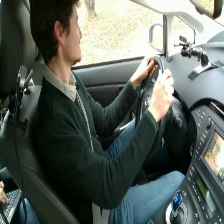

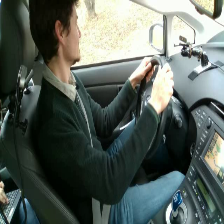

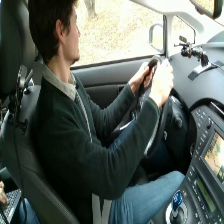

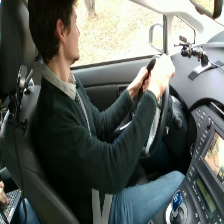

Displaying Gaze_on_road Frames:


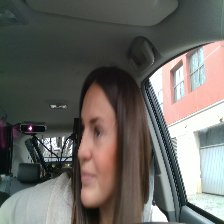

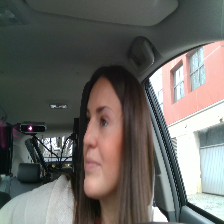

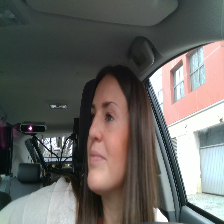

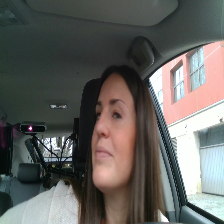

Displaying Hands_using_wheel Frames:


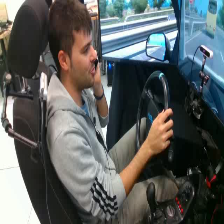

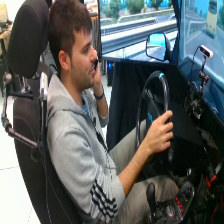

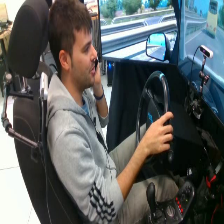

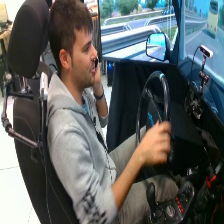

In [ ]:
# Display frames for each modality
display_video(driver_video_np, "Driver_actions")
display_video(gaze_video_np, "Gaze_on_road")
display_video(hands_video_np, "Hands_using_wheel")


In [ ]:
!pip install pytorchvideo
!pip install torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 55.5 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=6c5046fe6c37f4663a3349fae823414c5f2c7435fb45fff7fcb556eb5612eb52
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=9630ee9ce5dc157e47683107a4c97825ba0b78f9170ef3444c365dc29f227963
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models.video as models
import torch
from pytorchvideo.models import resnet
from transformers import get_linear_schedule_with_warmup

In [ ]:
def build_resnet_model(num_classes, device, dtype):
  # Initialize the model with explicit device and dtype
    resnet_model = resnet.create_resnet(
    input_channel=3,
    model_depth=50,
    model_num_class=num_classes
    ).to(device=device, dtype=dtype)
    return resnet_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

actions_resnet_model = build_resnet_model(10, device, dtype)
gaze_resnet_model = build_resnet_model(2, device, dtype)
hands_resnet_model = build_resnet_model(4, device, dtype)
# actions_train_dataloader, actions_test_dataloader,gaze_train_dataloader, gaze_test_dataloader,hands_train_dataloader, hands_test_dataloader

In [ ]:
GAZE_MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/gaze_resnet_model.pth'
HANDS_MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/hands_resnet_model.pth'
MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/resnet_model.pth'

In [ ]:
# Load the hands model
hands_resnet_model.load_state_dict(torch.load(HANDS_MODEL_SAVE_PATH))

# Load the gaze model
gaze_resnet_model.load_state_dict(torch.load(GAZE_MODEL_SAVE_PATH))

# Load the actions model
actions_resnet_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<ipython-input-18-1e800e44af0f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hands_resnet_model.load_state_dict(torch.load(HANDS_MODEL_SAVE_PATH))
<ipython-input-18-1e80

<All keys matched successfully>

In [ ]:
hands_resnet_model.eval()
gaze_resnet_model.eval()
actions_resnet_model.eval()

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (branch1_norm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm.auto import tqdm


# Danger Scores for Each Modality
ACTIONS_DANGER_SCORES = {
    "safe_drive": 0.0,
    "phonecall_left": 1,
    "phonecall_right": 1,
    "reach_side": 1,
    "texting_left":1,
    "texting_right": 1,
    "hair_and_makeup":1,
    "radio": 1,
    "drinking": 1,
    "reach_backseat": 1.0,
}

GAZE_DANGER_SCORES = {
    "looking_road": 0.0,
    "not_looking_road": 1.0,
}

HANDS_DANGER_SCORES = {
    "both": 0.0,
    "only_left": 0.5,
    "only_right": 0.5,
    "none": 1.0,
}

# Dataset Class
class MultiModalVideoDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None, clip_len=20):
        self.data = data
        self.transform = transform
        self.clip_len = clip_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        driver_path, gaze_path, hands_path, label = self.data[idx]
        driver_tensor = self._process_video(driver_path)
        gaze_tensor = self._process_video(gaze_path)
        hands_tensor = self._process_video(hands_path)
        return (driver_tensor, gaze_tensor, hands_tensor), label

    def _process_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (224, 224))
            frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame_tensor)
        cap.release()
        if len(frames) > self.clip_len:
            frames = frames[:self.clip_len]
        elif len(frames) < self.clip_len:
            frames.extend([frames[-1]] * (self.clip_len - len(frames)))
        return torch.stack(frames).permute(1, 0, 2, 3)

# Danger Score Computation
def compute_danger_scores_parallel(models, tensors, danger_scores_list, device):
    frame_scores = []
    with torch.no_grad():
        for model, tensor, danger_scores in zip(models, tensors, danger_scores_list):
            model.eval()
            tensor = tensor.to(device)
            outputs = model(tensor)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions = np.argmax(probabilities, axis=1)
            scores = [danger_scores[list(danger_scores.keys())[pred]] for pred in predictions]
            frame_scores.append(np.mean(scores))
    return frame_scores

# Aggregated Scores
def aggregate_scores(actions_scores, gaze_scores, hands_scores, weights=None):
    if weights is None:
        weights = [1.0, 1.0, 1.0]
    return [
        (weights[0] * a + weights[1] * g + weights[2] * h) / sum(weights)
        for a, g, h in zip(actions_scores, gaze_scores, hands_scores)
    ]

# Smoothing Scores
def smooth_scores(scores, window_size=10):
    return np.convolve(scores, np.ones(window_size) / window_size, mode="valid")

# Alarm Trigger
def trigger_alarm(smoothed_scores, threshold=0.6):
    return [i for i, score in enumerate(smoothed_scores) if score > threshold]

# Evaluation Metrics
def calculate_metrics(y_true, y_pred, y_scores, threshold):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        roc_auc = np.nan
    conf_matrix = confusion_matrix(y_true, y_pred)
    alarm_indices = [i for i, score in enumerate(y_scores) if score > threshold]
    time_to_alarm = alarm_indices[0] if alarm_indices else np.inf
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": conf_matrix,
        "time_to_alarm": time_to_alarm,
    }

# Main Workflow
def predict_and_evaluate_parallel(models, multi_modal_dataset, device, threshold=0.5, weights=None):
    dataloader = DataLoader(multi_modal_dataset, batch_size=1, shuffle=False)
    aggregated_scores = []
    y_true = []
    danger_scores_list = [ACTIONS_DANGER_SCORES, GAZE_DANGER_SCORES, HANDS_DANGER_SCORES]

    for (driver_tensor, gaze_tensor, hands_tensor), label in tqdm(dataloader, desc="Predicting"):
        tensors = (driver_tensor, gaze_tensor, hands_tensor)
        danger_scores = compute_danger_scores_parallel(models, tensors, danger_scores_list, device)
        # print(f"danger_scores: {danger_scores}")
        if weights is None:
            weights = [1.0, 1.0, 1.0]
        aggregated_score = np.dot(weights, danger_scores) / sum(weights)
        aggregated_scores.append(aggregated_score)
        y_true.append(label.item())

    smoothed_scores = smooth_scores(aggregated_scores, window_size=50)
    # y_pred = [1 if score > threshold else 0 for score in smoothed_scores]
    y_pred = [1 if score > threshold else 0 for score in aggregated_scores]
    print(f"{y_pred}")
    print(f"{y_true}")
    metrics = calculate_metrics(y_true[:len(y_pred)], y_pred, aggregated_scores[:len(y_pred)], threshold)

    print(f"Optimal Threshold (T_safe): {threshold}")
    print(f"Metrics:\n{metrics}")
    return metrics, aggregated_scores, smoothed_scores



In [ ]:
# Example Usage
# Assuming pre-trained models and dataset are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [actions_resnet_model, gaze_resnet_model, hands_resnet_model]

metrics, aggregated_scores, smoothed_scores = predict_and_evaluate_parallel(
    models,
    multi_modal_dataset,
    device,
    threshold=0.4,
    weights=[1, 1, 1]
 )


Predicting:   0%|          | 0/900 [00:00<?, ?it/s]

[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

In [ ]:
metrics, aggregated_scores, smoothed_scores = predict_and_evaluate_parallel(
    models,
    multi_modal_dataset,
    device,
    threshold=0.5,
    weights=[1, 1, 1]
 )

Predicting:   0%|          | 0/900 [00:00<?, ?it/s]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

In [ ]:
metrics, aggregated_scores, smoothed_scores = predict_and_evaluate_parallel(
    models,
    multi_modal_dataset,
    device,
    threshold=0.6,
    weights=[1, 1, 1]
 )

Predicting:   0%|          | 0/900 [00:00<?, ?it/s]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

In [ ]:
metrics, aggregated_scores, smoothed_scores = predict_and_evaluate_parallel(
    models,
    multi_modal_dataset,
    device,
    threshold=0.7,
    weights=[1, 1, 1]
 )

Predicting:   0%|          | 0/900 [00:00<?, ?it/s]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

In [ ]:
metrics, aggregated_scores, smoothed_scores = predict_and_evaluate_parallel(
    models,
    multi_modal_dataset,
    device,
    threshold=0.8,
    weights=[1, 1, 1]
 )

Predicting:   0%|          | 0/900 [00:00<?, ?it/s]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 

In [ ]:
metrics, aggregated_scores, smoothed_scores = predict_and_evaluate_parallel(
    models,
    multi_modal_dataset,
    device,
    threshold=0.9,
    weights=[1, 1, 1]
 )

Predicting:   0%|          | 0/900 [00:00<?, ?it/s]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 

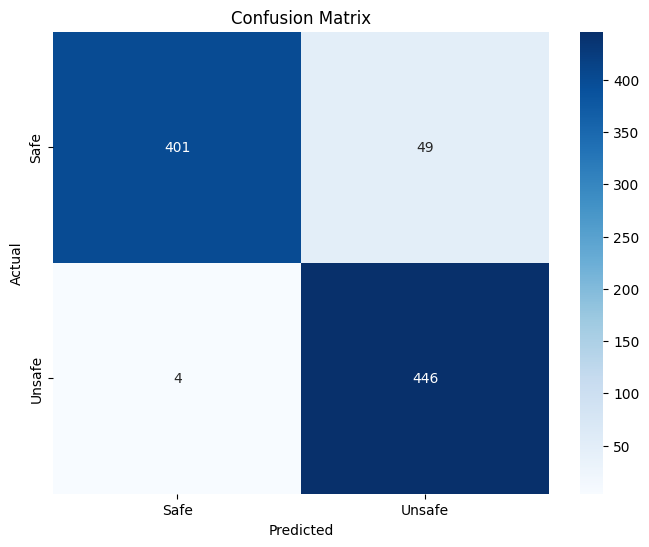

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plots the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix (np.ndarray): Confusion matrix values.
        class_names (list): List of class names corresponding to matrix indices.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Example Confusion Matrix and Class Names
conf_matrix_example = np.array([[401, 49],[ 4, 446]])  # Replace with your actual confusion matrix
class_names_example = ["Safe", "Unsafe"]  # Replace with your actual class names

plot_confusion_matrix(conf_matrix_example, class_names_example)
